In [ ]:
# !pip install pandas transformers torch datasets pyarrow fastparquet ragas pymilvus
# !pip install sentence-transformers
# !pip install "pymilvus[milvus_lite]"
# !pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
import torch, platform
print("CUDA available:", torch.cuda.is_available(), "Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: True Device: Tesla T4


In [ ]:
# Load all required Libraries
import pandas as pd
import transformers, torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset

from pymilvus import MilvusClient, FieldSchema, CollectionSchema, DataType

from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

# Read Passages from the Datasets and Drop rows if they are NA or empty

In [ ]:
passages = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")

print(passages.shape)
passages.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(3200, 1)


,passage
id,
0,"Uruguay (official full name in ; pron. , Eas..."
1,"It is bordered by Brazil to the north, by Arge..."
2,Montevideo was founded by the Spanish in the e...
3,The economy is largely based in agriculture (m...
4,"According to Transparency International, Urugu..."


# Do EDA on the passage dataset
- You can try to find the maximum and minimum length of the passages before indexing (just a direction)

In [ ]:
# Check for missing values
print("Number of missing passages:", passages['passage'].isna().sum())

# Compute passage lengths (number of characters and number of words)
passages['char_length'] = passages['passage'].apply(len)
passages['word_length'] = passages['passage'].apply(lambda x: len(x.split()))

# Basic statistics
print("Character length stats:")
print(passages['char_length'].describe())

print("\nWord length stats:")
print(passages['word_length'].describe())

# Find the shortest and longest passage examples
print("\nShortest passage:\n", passages.loc[passages['char_length'].idxmin(), 'passage'])
print("\nLongest passage:\n", passages.loc[passages['char_length'].idxmax(), 'passage'])

Number of missing passages: 0
Character length stats:
count    3200.000000
mean      389.848125
std       348.368869
min         1.000000
25%       108.000000
50%       299.000000
75%       574.000000
max      2515.000000
Name: char_length, dtype: float64

Word length stats:
count    3200.000000
mean       62.103750
std        55.422049
min         1.000000
25%        17.000000
50%        48.000000
75%        92.000000
max       425.000000
Name: word_length, dtype: float64

Shortest passage:
 |

Longest passage:
 As Ford approached his ninetieth year, he began to experience significant health problems associated with old age. He suffered two minor strokes at the 2000 Republican National Convention, but made a quick recovery.  Gerald Ford recovering after strokes. BBC, August 2, 2000.  Retrieved on December 31, 2006.  In January 2006, he spent 11 days at the Eisenhower Medical Center near his residence at Rancho Mirage, California, for treatment of pneumonia.  Former President Ford, 92,

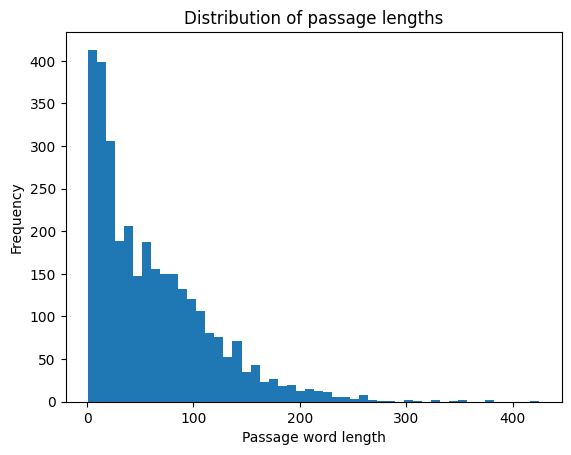

In [ ]:
import matplotlib.pyplot as plt

plt.hist(passages['word_length'], bins=50)
plt.xlabel("Passage word length")
plt.ylabel("Frequency")
plt.title("Distribution of passage lengths")
plt.show()

# Tokenize Text and Generate Embeddings using Sentence Transformers

In [ ]:
from sentence_transformers import SentenceTransformer

# Load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode all passages into embeddings
embeddings = embedding_model.encode(
    passages["passage"].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print("Embeddings shape:", embeddings.shape)

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Embeddings shape: (3200, 384)


# Create Milvus Client and Insert your Embeddings to your DB
- Make sure you define a schema for your collection (Points will be deducted if you fail to define a proper schema with ids, passage text, embedding)

In [ ]:
from pymilvus import MilvusClient, FieldSchema, CollectionSchema, DataType

# Define fields
id_ = FieldSchema(
    name="id",
    dtype=DataType.INT64,
    is_primary=True,
    auto_id=False
)

passage = FieldSchema(
    name="passage",
    dtype=DataType.VARCHAR,
    max_length=1000
)

embedding = FieldSchema(
    name="embedding",
    dtype=DataType.FLOAT_VECTOR,
    dim=embeddings.shape[1]
)

# Build schema
schema = CollectionSchema(
    fields=[id_, passage, embedding],
    description="RAG mini Wikipedia passages"
)

In [ ]:
client = MilvusClient("rag_wikipedia_mini.db")

# Create collection
# client.drop_collection("rag_mini")
client.create_collection(
    collection_name="rag_mini",
    schema=schema
)

# Prepare data for insertion
ids = [int(i) for i in range(len(passages))]
texts = passages["passage"].astype(str).tolist()
vecs = embeddings.tolist()

data = [
    {"id": ids[i], "passage": texts[i], "embedding": vecs[i]}
    for i in range(len(ids))
]

# Insert into Milvus
res = client.insert(
    collection_name="rag_mini",
    data=data
)

print("Inserted", res["insert_count"], "rows into Milvus")

Inserted 3200 rows into Milvus


In [ ]:
print("Entity count:", client.get_collection_stats("rag_mini")["row_count"])
print("Collection schema:", client.describe_collection("rag_mini"))

Entity count: 6400
Collection schema: {'collection_name': 'rag_mini', 'auto_id': False, 'num_shards': 0, 'description': 'RAG mini Wikipedia passages', 'fields': [{'field_id': 100, 'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'params': {}, 'is_primary': True}, {'field_id': 101, 'name': 'passage', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1000}}, {'field_id': 102, 'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}], 'functions': [], 'aliases': [], 'collection_id': 0, 'consistency_level': 0, 'properties': {}, 'num_partitions': 0, 'enable_dynamic_field': False}


# Steps to Fetch Results
- Read the Question Dataset
- Clean the Question Dataset if necessary (Drop Questions with NaN etc.)
- Convert Each Query to a Vector Embedding (Use the same embedding model you used to embed your document)
- Try for a Single Question First
- Load Collection into Memory after creating Index for Search on your embedding field (This is an essential step before you can search in your db)
- Search and Fetch Top N Results

In [ ]:
import pandas as pd

queries = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet")
queries

,question,answer
id,,
0,Was Abraham Lincoln the sixteenth President of...,yes
2,Did Lincoln sign the National Banking Act of 1...,yes
4,Did his mother die of pneumonia?,no
6,How many long was Lincoln's formal education?,18 months
8,When did Lincoln begin his political career?,1832
...,...,...
1710,Was Wilson president of the American Political...,Yes
1711,Did he not cast his ballot for John M. Palmer ...,Yes
1712,Did Wilson not spend 1914 through the beginnin...,Yes


In [ ]:
# Pick a single query from the test set
query = queries["question"].iloc[0]
print("Sample query:", query)

# Encode the query to embedding (same model as documents)
query_embedding = embedding_model.encode(
    [query],
    normalize_embeddings=True,
    convert_to_numpy=True
)

print("Query embedding shape:", query_embedding.shape)

Sample query: Was Abraham Lincoln the sixteenth President of the United States?
Query embedding shape: (1, 384)


In [ ]:
# Build IVF_FLAT index for Milvus Lite (HNSW is not supported in local mode)
from pymilvus import MilvusClient

# Release then drop existing index (safe to ignore failures)
try:
    client.release_collection("rag_mini")
except Exception:
    pass
try:
    client.drop_index(collection_name="rag_mini", field_name="embedding")
except Exception:
    pass

# Create IVF_FLAT index (use dict for params)
index_params = MilvusClient.prepare_index_params()
index_params.add_index(
    field_name="embedding",
    index_type="IVF_FLAT",        # valid in Milvus Lite
    metric_type="COSINE",
    params={"nlist": 64}          # ~sqrt(3200) -> 64
)

res = client.create_index(collection_name="rag_mini", index_params=index_params)
print("create_index:", res)

# Load AFTER index is created
client.load_collection("rag_mini")
print("collection loaded (IVF_FLAT index)")

# Optional sanity check
try:
    print("index_info:", client.describe_index("rag_mini", "embedding"))
except Exception as e:
    print("describe_index error:", e)

create_index: None
collection loaded (IVF_FLAT index)
index_info: {'index_type': 'IVF_FLAT', 'metric_type': 'COSINE', 'nlist': '64', 'dim': '384', 'field_name': 'embedding', 'index_name': 'embedding', 'total_rows': 0, 'indexed_rows': 0, 'pending_index_rows': 0, 'state': 'Finished'}


In [ ]:

# Step 4: Run a search using the query embedding
output_ = client.search(
    collection_name="rag_mini",
    data=query_embedding.tolist(),
    anns_field="embedding",
    limit=3,                   # top-k results
    output_fields=["id", "passage"]
)

print("Search results:")
for hit in output_[0]:
    print(f"score={hit['distance']:.4f}, passage={hit['entity']['passage'][:100]}...")

Search results:
score=0.7095, passage=Young Abraham Lincoln...
score=0.5840, passage=Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United Sta...


## Now get the Context
- Initially use the first passage ONLY as your context
- In Later Experiments, you must try at least 2 different passage selection strategies (Top 3 / Top 5 / Top 10) and pass to your prompt

In [ ]:
# Take the first retrieved passage as context
context = output_[0][0]["entity"]["passage"]
context

system_prompt = f"You are a helpful assistant. Answer the question based only on the given context."

# Build the final prompt
prompt = f"""{system_prompt}

Context:
{context}

Question: {query}
Answer:"""

print(prompt)

You are a helpful assistant. Answer the question based only on the given context.

Context:
Young Abraham Lincoln

Question: Was Abraham Lincoln the sixteenth President of the United States?
Answer:


# RAG Response for a Single Query

In [ ]:
# Load the LLM Model you want to use
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-base"

tok = AutoTokenizer.from_pretrained(model_name)
lm  = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [ ]:
# Encode the prompt
inputs = tok(prompt, return_tensors="pt", truncation=True, max_length=2048)

# Generate
gen_ids = lm.generate(
    **inputs,
    max_new_tokens=128,
    do_sample=False,          # set True for sampling
    num_beams=4,              # simple beam search for better determinism
    length_penalty=0.0,       # prefer concise answers
    early_stopping=True
)

# Decode and extract answer.
answer_text = tok.decode(gen_ids[0], skip_special_tokens=True)
print("Answer:", answer_text)

Answer: yes


# Generate Responses for all the Queries in the Dataset

In [ ]:
# Search-time params: lower nprobe -> faster; higher nprobe -> better recall
SEARCH_PARAMS = {"metric_type": "COSINE", "params": {"nprobe": 16}}

preds, refs = [], []

# Keep N small for speed on local CPU.
N = 100

for i, row in queries.iloc[:N].iterrows():
    print(i, end=" ")
    question = row["question"]
    gold_answer = str(row["answer"])

    # Encode query and search top-1 passage from Milvus (collection: rag_mini)
    q_vec = embedding_model.encode([question], normalize_embeddings=True, convert_to_numpy=True).tolist()
    hits = client.search(
        collection_name="rag_mini",
        data=q_vec,
        anns_field="embedding",
        limit=1,
        output_fields=["id", "passage"],
        params=SEARCH_PARAMS
    )
    context_text = hits[0][0]["entity"]["passage"] if hits and hits[0] else ""

    # Build prompt
    sys_prompt = "You are a helpful assistant. Answer the question based only on the given context."
    prompt_local = f"""{sys_prompt}

Context:
{context_text}

Question: {question}
Answer:"""

    # Generate answer with flan-t5-base
    inputs = tok(prompt_local, return_tensors="pt", truncation=True, max_length=2048)
    gen_ids = lm.generate(**inputs, max_new_tokens=128, do_sample=False, num_beams=4, early_stopping=True)
    pred_text = tok.decode(gen_ids[0], skip_special_tokens=True)

    # Collect prediction and reference for SQuAD metric
    preds.append({"id": str(i), "prediction_text": pred_text})
    refs.append({"id": str(i), "answers": {"text": [gold_answer], "answer_start": [0]}})

0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 37 39 41 43 45 47 49 51 53 80 83 86 89 92 95 98 101 115 118 123 131 136 139 140 141 142 143 144 145 146 147 148 149 150 151 153 154 155 156 158 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188 190 192 193 194 195 196 197 198 199 200 201 202 203 204 206 208 210 212 214 216 218 219 221 223 225 227 229 

In [ ]:
import evaluate
squad = evaluate.load("squad")

results = squad.compute(predictions=preds, references=refs)
print(results)  # {'exact_match': ..., 'f1': ...}

{'exact_match': 50.0, 'f1': 55.18721629247944}


# Advanced Evaluation using RAGAs

Please see `advacned_evaluation.ipynb`